In [1]:
!pip install scikit-optimize

In [31]:
import pandas as pd
import numpy as np
from scipy import stats
from skopt import gp_minimize
import matplotlib.pyplot as plt

# Load your dataset with error handling
def load_data(file_path):
    try:
        data = pd.read_excel(file_path)
        data['DateTime'] = pd.to_datetime(data['DateTime'])
        data.set_index('DateTime', inplace=True)
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load the dataset
file_path = 'EnsemblePredictions.xlsx'  # Update this path
data = load_data(file_path)

if data is not None:
    # Define the depths and decay constant
    depths = [10, 20, 40, 80]
    alpha = 0.3  # Decay rate

    # Calculate exponential decay weights and normalize them
    raw_weights = [np.exp(-alpha * d) for d in depths]
    normalized_weights = [w / sum(raw_weights) for w in raw_weights]

    # Map normalized weights to depth columns
    weights = {
        'SoilTemp_10cm': normalized_weights[0],
        'SoilTemp_20cm': normalized_weights[1],
        'SoilTemp_40cm': normalized_weights[2],
        'SoilTemp_80cm': normalized_weights[3]
    }

    # Calculate RZT using the exponential decay weights
    def calculate_rzt(data, weights):
        """Calculates the Root Zone Temperature (RZT) based on soil temperatures and their weights."""
        data['RZT'] = (
            data['SoilTemp_10cm'] * weights['SoilTemp_10cm'] +
            data['SoilTemp_20cm'] * weights['SoilTemp_20cm'] +
            data['SoilTemp_40cm'] * weights['SoilTemp_40cm'] +
            data['SoilTemp_80cm'] * weights['SoilTemp_80cm']
        )
        return data

    # Calculate RZT and update the dataset
    data = calculate_rzt(data, weights)

    # Define time intervals based on the index
    conditions = [
        (data.index.hour < 6),
        (data.index.hour >= 6) & (data.index.hour < 12),
        (data.index.hour >= 12) & (data.index.hour < 17),
        (data.index.hour >= 17)
    ]
    choices = ['Night', 'Morning', 'Afternoon', 'Evening']

    # Create TimeOfDay column
    data['TimeOfDay'] = np.select(conditions, choices)

    # Calculate min and max RZT values before optimization
    rzt_before_optimization = data.groupby('TimeOfDay')['RZT'].agg(['min', 'max'])
    
    print("Before Optimization:")
    for time_of_day, row in rzt_before_optimization.iterrows():
        print(f"{time_of_day} - Min RZT: {row['min']:.2f}°C, Max RZT: {row['max']:.2f}°C")

    # Define dynamic bounds for optimization based on the data
    lower_bound = max(10, data['RZT'].min())  # Lower bound can be reduced
    upper_bound = min(35, data['RZT'].max() + 5)  # Upper bound can be increased
    bounds = [(lower_bound, upper_bound)]  # Bounds for RZT

    # Define an objective function that evaluates each entry's RZT value
    def comprehensive_objective(rzt):
        """Objective function to minimize based on individual entries."""
        penalties = []
        
        rzt_value = rzt[0]  # Extract single value from list
        
        for index, row in data.iterrows():
            ideal_temp = 25
            
            if rzt_value < lower_bound:
                penalties.append((lower_bound - rzt_value) ** 2 * 2)  # Strong penalty for being too low
            elif rzt_value > upper_bound:
                penalties.append((rzt_value - upper_bound) ** 2 * 2)  # Strong penalty for being too high
            elif rzt_value > ideal_temp:
                penalties.append((rzt_value - ideal_temp) ** 2 * 1.5)  # Encourage reaching ideal temp
            else:
                penalties.append((ideal_temp - rzt_value) ** 2 * 1.5)  # Encourage reaching ideal temp
        
        return np.mean(penalties)


Before Optimization:
Afternoon - Min RZT: 17.25°C, Max RZT: 32.62°C
Evening - Min RZT: 17.26°C, Max RZT: 32.45°C
Morning - Min RZT: 17.24°C, Max RZT: 35.01°C
Night - Min RZT: 17.25°C, Max RZT: 33.31°C


In [2]:
!pip install openpyxl

In [4]:
!pip install tqdm

In [5]:
from tqdm import tqdm 
# Function to run optimization for a single row
def optimize_row(row):
    res = gp_minimize(
        comprehensive_objective,
        bounds,
        n_calls=20,  # Reduced number of calls
        acq_func='EI',
        random_state=42,
        x0=[row['RZT']]  # Start with current RZT value as initial point
    )
    return res.x[0]  # Return optimized value

# Run Bayesian optimization without parallel processing with tqdm progress bar
optimized_rzts = []
for _, row in tqdm(data.iterrows(), total=data.shape[0], desc="Optimizing RZT"):
    optimized_rzt = optimize_row(row)
    optimized_rzts.append(optimized_rzt)

# Add optimized values back to DataFrame for comparison
data['Optimized_RZT'] = optimized_rzts

print("\nAfter Optimization:")

# Display optimized RZT values along with min and max values after optimization.
for timeframe in data['TimeOfDay'].unique():
    current_min = data[data['TimeOfDay'] == timeframe]['RZT'].min()
    current_max = data[data['TimeOfDay'] == timeframe]['RZT'].max()
    
    optimized_min_after_opt = min(current_min, data[data['TimeOfDay'] == timeframe]['Optimized_RZT'].min())
    optimized_max_after_opt = max(current_max, data[data['TimeOfDay'] == timeframe]['Optimized_RZT'].max())
    
    print(f"{timeframe} - Optimized Min RZT: {optimized_min_after_opt:.2f}°C, "
          f"Optimized Max RZT: {optimized_max_after_opt:.2f}°C")


Optimizing RZT: 100%|██████████████████████████████████████████████████████████▉| 7199/7200 [10:05:47<00:05,  5.05s/it]


ValueError: Not all points are within the bounds of the space.

In [8]:
print(len(optimized_rzts))

7199


In [9]:
print(optimized_rzts)

[24.996580761609042, 25.000377278128095, 24.999938888708044, 24.976489144226754, 25.000996243120678, 24.994382173634598, 24.999912880532555, 24.984341586385042, 24.995544607393466, 24.99775405364647, 25.01533217467104, 25.00062750815935, 25.006031755903035, 24.98681943661137, 24.999262442309643, 25.000572653399853, 25.00565630089201, 25.013018388862516, 24.986241013649106, 24.99984831069112, 25.000811569425082, 24.999090036771207, 24.99981201476006, 25.002575550811557, 24.97788359666285, 24.996742275355338, 24.99261009590903, 24.991798469184964, 25.020884687159807, 25.01236269993107, 24.99775405364647, 24.987430634268755, 25.00330258983032, 24.99113387474823, 25.018171013902922, 25.002097505769576, 24.996971057181806, 25.002024073629023, 24.99639796956884, 24.99697104019599, 25.01726143735189, 24.996971057181806, 25.002097505769576, 24.996356636845405, 24.97725152826301, 24.992944266089545, 25.001919020762024, 24.99677369027619, 25.006542994330655, 24.99528295254493, 24.996971057181824

In [14]:
if len(optimized_rzts) < len(data):
    optimized_rzts += [None] * (len(data) - len(optimized_rzts))

# Add optimized values back to the original DataFrame for comparison
data['Optimized_RZT'] = optimized_rzts

print("\nAfter Optimization:")

# Display optimized RZT values along with min and max values after optimization.
for timeframe in data['TimeOfDay'].unique():
 
    
    optimized_min_after_opt = data[data['TimeOfDay'] == timeframe]['Optimized_RZT'].min()
    optimized_max_after_opt = data[data['TimeOfDay'] == timeframe]['Optimized_RZT'].max()
    
    print(f"{timeframe} - Optimized Min RZT: {optimized_min_after_opt:.2f}°C, "
          f"Optimized Max RZT: {optimized_max_after_opt:.2f}°C")

# Save the updated DataFrame to a CSV file (optional)
data.to_csv('optimized_results.csv', index=False)


After Optimization:
Morning - Optimized Min RZT: 24.96°C, Optimized Max RZT: 25.03°C
Afternoon - Optimized Min RZT: 24.96°C, Optimized Max RZT: 25.05°C
Evening - Optimized Min RZT: 24.95°C, Optimized Max RZT: 25.05°C
Night - Optimized Min RZT: 24.95°C, Optimized Max RZT: 25.04°C


In [17]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
    explained_variance_score,
    max_error,
    mean_poisson_deviance,
    mean_tweedie_deviance
)

In [50]:
import pandas as pd

# Load the optimized results dataset
file_path = 'optimized_results.csv'  # Update this path if necessary
try:
    data = pd.read_csv(file_path)
    
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")

# Display the first few rows of the loaded DataFrame
print(data.head())

Data loaded successfully.
   SoilTemp_10cm  SoilTemp_20cm  SoilTemp_40cm  SoilTemp_80cm  \
0      17.321832      18.108092      14.359191      14.935912   
1      17.326594      18.110410      14.358569      14.936509   
2      17.365712      18.130760      14.345367      14.937842   
3      17.406489      18.154685      14.331040      14.939203   
4      17.450200      18.179308      14.315960      14.940576   

   SoilHeatFlux_DiffVolt1        RZT TimeOfDay  Optimized_RZT  
0                -0.21920  17.358768   Morning      24.996581  
1                -0.23159  17.363414   Morning      25.000377  
2                -0.25604  17.401636   Morning      24.999939  
3                -0.27770  17.441607   Morning      24.976489  
4                -0.28922  17.484406   Morning      25.000996  


In [57]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    max_error,
)

# Load the optimized results dataset
file_path = 'optimized_results.csv'  # Update this path if necessary
try:
    data = pd.read_csv(file_path)
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")

# Define the ideal optimal temperature
ideal_temp = 25  # Ideal temperature

# Get the predicted values from the DataFrame
y_pred = data['Optimized_RZT']

# Create an array of ideal temperatures matching the length of y_pred
y_true = np.full_like(y_pred, ideal_temp, dtype=float)  # Use constant ideal temperature

# Remove NaN values if present in predictions or true values before metric calculations.
mask = ~np.isnan(y_pred)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true_filtered, y_pred_filtered))
mae = mean_absolute_error(y_true_filtered, y_pred_filtered)
mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / ideal_temp))   # Convert to percentage
smape = np.mean(2 * np.abs(y_pred_filtered - y_true_filtered) / (np.abs(y_true_filtered) + np.abs(y_pred_filtered)))   # Convert to percentage

explained_variance = explained_variance_score(y_true_filtered, y_pred_filtered)
max_err = max_error(y_true_filtered, y_pred_filtered)

# Print metrics
print("\nMetrics:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"SMAPE: {smape}")

print(f"Max Error: {max_err:.5f}")

Data loaded successfully.

Metrics:
RMSE: 0.009097657950550411
MAE: 0.006040156470454399
MAPE: 0.000241606258818176
SMAPE: 0.00024160528676942655
Max Error: 0.05147


In [51]:
# Create a summary table for optimized RZT values by timeframe
summary_table = data.groupby('TimeOfDay')['Optimized_RZT'].agg(['min', 'max']).reset_index()
summary_table.columns = ['Timeframe', 'Min Optimized RZT', 'Max Optimized RZT']

# Display the summary table
print("\nSummary Table:")
print(summary_table)


Summary Table:
   Timeframe  Min Optimized RZT  Max Optimized RZT
0  Afternoon          24.957615          25.047728
1    Evening          24.952821          25.045548
2    Morning          24.955557          25.030220
3      Night          24.948534          25.040590


In [52]:
# Calculate accuracy based on how many predictions are within a certain range of the ideal temperature
accuracy_threshold = 1 # Define an accuracy threshold of ±1°C around the ideal temperature
predictions_within_threshold = np.abs(y_pred - ideal_temp) <= accuracy_threshold

accuracy_percentage = np.mean(predictions_within_threshold) * 100
print(f"Accuracy (% within ±{accuracy_threshold}°C): {accuracy_percentage}%")

Accuracy (% within ±1°C): 99.98611111111111%


In [76]:
import pandas as pd
import numpy as np
from scipy import stats
from skopt import gp_minimize
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load your dataset with error handling
def load_data(file_path):
    try:
        data = pd.read_excel(file_path)
        data['DateTime'] = pd.to_datetime(data['DateTime'])
        data.set_index('DateTime', inplace=True)
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load the dataset
file_path = 'EnsemblePredictions.xlsx'  # Update this path
data = load_data(file_path)

if data is not None:
    # Define the depths and decay constant
    depths = [10, 20, 40, 80]
    alpha = 0.3  # Decay rate

    # Calculate exponential decay weights and normalize them
    raw_weights = [np.exp(-alpha * d) for d in depths]
    normalized_weights = [w / sum(raw_weights) for w in raw_weights]

    # Map normalized weights to depth columns
    weights = {
        'SoilTemp_10cm': normalized_weights[0],
        'SoilTemp_20cm': normalized_weights[1],
        'SoilTemp_40cm': normalized_weights[2],
        'SoilTemp_80cm': normalized_weights[3]
    }

    # Calculate RZT using the exponential decay weights
    def calculate_rzt(data, weights):
        """Calculates the Root Zone Temperature (RZT) based on soil temperatures and their weights."""
        data['RZT'] = (
            data['SoilTemp_10cm'] * weights['SoilTemp_10cm'] +
            data['SoilTemp_20cm'] * weights['SoilTemp_20cm'] +
            data['SoilTemp_40cm'] * weights['SoilTemp_40cm'] +
            data['SoilTemp_80cm'] * weights['SoilTemp_80cm']
        )
        return data

    # Calculate RZT and update the dataset
    data = calculate_rzt(data, weights)

    # Define time intervals based on the index
    conditions = [
        (data.index.hour < 6),
        (data.index.hour >= 6) & (data.index.hour < 12),
        (data.index.hour >= 12) & (data.index.hour < 17),
        (data.index.hour >= 17)
    ]
    choices = ['Night', 'Morning', 'Afternoon', 'Evening']

    # Create TimeOfDay column
    data['TimeOfDay'] = np.select(conditions, choices)

    # Calculate min and max RZT values before optimization
    rzt_before_optimization = data.groupby('TimeOfDay')['RZT'].agg(['min', 'max'])
    
    print("Before Optimization:")
    for time_of_day, row in rzt_before_optimization.iterrows():
        print(f"{time_of_day} - Min RZT: {row['min']:.2f}°C, Max RZT: {row['max']:.2f}°C")

    # Define dynamic bounds for optimization based on the data
    lower_bound = max(10, data['RZT'].min())  # Lower bound can be reduced
    upper_bound = min(35, data['RZT'].max() + 5)  # Upper bound can be increased
    bounds = [(lower_bound, upper_bound)]  # Bounds for RZT

    # Define an objective function that evaluates each entry's RZT value
    def comprehensive_objective(rzt):
        """Objective function to minimize based on individual entries."""
        penalties = []
        
        rzt_value = rzt[0]  # Extract single value from list
        
        for index, row in data.iterrows():
            ideal_temp_low = 18
            ideal_temp_high = 25
            
            if rzt_value < lower_bound:
                penalties.append((lower_bound - rzt_value) ** 2 * 2)  # Strong penalty for being too low
            elif rzt_value > upper_bound:
                penalties.append((rzt_value - upper_bound) ** 2 * 2)  # Strong penalty for being too high
            elif rzt_value < ideal_temp_low:
                penalties.append((ideal_temp_low - rzt_value) ** 2 * 1.5)  # Penalty for being too low
            elif rzt_value > ideal_temp_high:
                penalties.append((rzt_value - ideal_temp_high) ** 2 * 1.5)  # Penalty for being too high
            else:
                penalties.append(0)  # No penalty if within the ideal range
        
        # Handle potential NaN values
        penalties = [penalty if not np.isnan(penalty) else 0 for penalty in penalties]
        
        return np.mean(penalties)

    # Function to run optimization for a single row
    def optimize_row(row):
        res = gp_minimize(
            comprehensive_objective,
            bounds,
            n_calls=20,  # Reduced number of calls
            acq_func='EI',
            random_state=42,
            x0=[row['RZT']]  # Start with current RZT value as initial point
        )
        return res.x[0]  # Return optimized value

    # Run Bayesian optimization without parallel processing with tqdm progress bar
    optimized_rzts = []
    for _, row in tqdm(data.iterrows(), total=data.shape[0], desc="Optimizing RZT"):
        optimized_rzt = optimize_row(row)
        optimized_rzts.append(optimized_rzt)

    # Add optimized values back to DataFrame for comparison
    data['Optimized_RZT'] = optimized_rzts

    print("\nAfter Optimization:")

    # Display optimized RZT values along with min and max values after optimization.
    for timeframe in data['TimeOfDay'].unique():
        current_min = data[data['TimeOfDay'] == timeframe]['RZT'].min()
        current_max = data[data['TimeOfDay'] == timeframe]['RZT'].max()
        
        optimized_min_after_opt = min(current_min, data[data['TimeOfDay'] == timeframe]['Optimized_RZT'].min())
        optimized_max_after_opt = max(current_max, data[data['TimeOfDay'] == timeframe]['Optimized_RZT'].max())
        
        print(f"{timeframe} - Optimized Min RZT: {optimized_min_after_opt:.2f}°C, "
              f"Optimized Max RZT: {optimized_max_after_opt:.2f}°C")


Before Optimization:
Afternoon - Min RZT: 17.25°C, Max RZT: 32.62°C
Evening - Min RZT: 17.26°C, Max RZT: 32.45°C
Morning - Min RZT: 17.24°C, Max RZT: 35.01°C
Night - Min RZT: 17.25°C, Max RZT: 33.31°C


Optimizing RZT: 100%|██████████████████████████████████████████████████████████▉| 7199/7200 [10:08:28<00:05,  5.07s/it]


ValueError: Not all points are within the bounds of the space.

In [77]:
print(optimized_rzts)

[20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 18.03181613707733, 18.310461800436457, 18.393330205154847, 18.4761986007149, 18.558327926525436, 18.53758161455143, 18.516761246560478, 18.49560705793404, 18.42184163836768, 18.348076979273436, 18.27431231612834, 18.23303652253157, 18.191764450549105, 18.150492492735456, 18.06445424211094, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49505846466887, 20.49

In [78]:
if len(optimized_rzts) < len(data):
    optimized_rzts += [None] * (len(data) - len(optimized_rzts))

# Add optimized values back to the original DataFrame for comparison
data['Optimized_RZT'] = optimized_rzts

print("\nAfter Optimization:")

# Display optimized RZT values along with min and max values after optimization.
for timeframe in data['TimeOfDay'].unique():
 
    
    optimized_min_after_opt = data[data['TimeOfDay'] == timeframe]['Optimized_RZT'].min()
    optimized_max_after_opt = data[data['TimeOfDay'] == timeframe]['Optimized_RZT'].max()
    
    print(f"{timeframe} - Optimized Min RZT: {optimized_min_after_opt:.2f}°C, "
          f"Optimized Max RZT: {optimized_max_after_opt:.2f}°C")

# Save the updated DataFrame to a CSV file (optional)
data.to_csv('optimized_results_1910.csv', index=False)


After Optimization:
Morning - Optimized Min RZT: 18.00°C, Optimized Max RZT: 24.93°C
Afternoon - Optimized Min RZT: 18.00°C, Optimized Max RZT: 24.59°C
Evening - Optimized Min RZT: 18.01°C, Optimized Max RZT: 24.99°C
Night - Optimized Min RZT: 18.01°C, Optimized Max RZT: 24.08°C


In [95]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    explained_variance_score,
    max_error,
)

# Load the optimized results dataset
file_path = 'optimized_results_1910.csv'  # Update this path if necessary
try:
    data = pd.read_csv(file_path)
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")

# Define the ideal optimal temperature range
ideal_temp_low = 18.00  # Minimum ideal temperature
ideal_temp_high = 25.00  # Maximum ideal temperature
ideal_temp_mean = (ideal_temp_low + ideal_temp_high) / 2  # Midpoint of the ideal range (21.5°C)

# Get the predicted values from the DataFrame
y_pred = data['Optimized_RZT']

# Create an array of the ideal midpoint temperature (21.5°C)
y_true = np.full_like(y_pred, ideal_temp_mean, dtype=float)

# Filter out NaN values if present in predictions before metric calculations
mask = ~np.isnan(y_pred)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Calculate the regression metrics
rmse = np.sqrt(mean_squared_error(y_true_filtered, y_pred_filtered))
mae = mean_absolute_error(y_true_filtered, y_pred_filtered)
mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / ideal_temp_mean))   # Convert to percentage
smape = np.mean(2 * np.abs(y_pred_filtered - y_true_filtered) / (np.abs(y_true_filtered) + np.abs(y_pred_filtered)))   # Convert to percentage

explained_variance = explained_variance_score(y_true_filtered, y_pred_filtered)
max_err = max_error(y_true_filtered, y_pred_filtered)

# Calculate the proportion of predicted values within the ideal temperature range (18-25°C)
within_range = (y_pred_filtered >= ideal_temp_low) & (y_pred_filtered <= ideal_temp_high)
percentage_within_range = np.sum(within_range) / len(y_pred_filtered) * 100

# Print the metrics
print("\nMetrics:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"SMAPE: {smape}")
print(f"Max Error: {max_err}")
print(f"Explained Variance: {explained_variance}")
print(f"Percentage of values within the optimal range (18-25°C): {percentage_within_range:.2f}%")


Data loaded successfully.

Metrics:
RMSE: 1.7582070426846619
MAE: 1.5220519743817684
MAPE: 0.07079311508752412
SMAPE: 0.07395064807160293
Max Error: 3.4999488812673683
Explained Variance: 0.0
Percentage of values within the optimal range (18-25°C): 100.00%


In [111]:
# Define multiple ranges for accuracy thresholds
threshold_ranges = [
    np.arange(3.44, 3.445, 0.001),  # Range 1
    np.arange(3.40, 3.45, 0.01),     # Range 2
    np.arange(3.30, 3.40, 0.05),     # Range 3
    np.arange(3.20, 3.30, 0.1)       # Range 4
]

# Initialize a list to store accuracies for each threshold
accuracies = []

# Loop through each range of thresholds
for threshold_range in threshold_ranges:
    print(f"\nChecking accuracy for thresholds in the range: {threshold_range[0]:.3f} to {threshold_range[-1]:.3f}")
    
    # Loop through each threshold in the current range
    for accuracy_threshold in threshold_range:
        # Calculate the proportion of predictions within the accuracy threshold around 18°C and 25°C
        within_threshold_low = np.abs(y_pred_filtered - ideal_temp_low) <= accuracy_threshold
        within_threshold_high = np.abs(y_pred_filtered - ideal_temp_high) <= accuracy_threshold

        # Combine the conditions: If a prediction is within the threshold for either lower or upper bound
        within_threshold = within_threshold_low | within_threshold_high

        # Calculate the accuracy as the proportion of predictions within the threshold
        accuracy_within_threshold = np.sum(within_threshold) / len(y_pred_filtered) * 100
        accuracies.append((accuracy_threshold, accuracy_within_threshold))

        # Print the accuracy for the current threshold
        print(f"Accuracy within threshold (±{accuracy_threshold:.3f}°C from 18°C or 25°C): {accuracy_within_threshold:.2f}%")

# Optionally, you can store accuracies in a DataFrame for further analysis
accuracy_df = pd.DataFrame(accuracies, columns=['Threshold', 'Accuracy'])


Checking accuracy for thresholds in the range: 3.440 to 3.444
Accuracy within threshold (±3.440°C from 18°C or 25°C): 99.35%
Accuracy within threshold (±3.441°C from 18°C or 25°C): 99.36%
Accuracy within threshold (±3.442°C from 18°C or 25°C): 99.40%
Accuracy within threshold (±3.443°C from 18°C or 25°C): 99.40%
Accuracy within threshold (±3.444°C from 18°C or 25°C): 99.40%

Checking accuracy for thresholds in the range: 3.400 to 3.450
Accuracy within threshold (±3.400°C from 18°C or 25°C): 99.03%
Accuracy within threshold (±3.410°C from 18°C or 25°C): 99.08%
Accuracy within threshold (±3.420°C from 18°C or 25°C): 99.14%
Accuracy within threshold (±3.430°C from 18°C or 25°C): 99.25%
Accuracy within threshold (±3.440°C from 18°C or 25°C): 99.35%
Accuracy within threshold (±3.450°C from 18°C or 25°C): 99.44%

Checking accuracy for thresholds in the range: 3.300 to 3.400
Accuracy within threshold (±3.300°C from 18°C or 25°C): 98.68%
Accuracy within threshold (±3.350°C from 18°C or 25°C):

In [114]:
print(accuracy_df)

    Threshold   Accuracy
0       3.440  99.347132
1       3.441  99.361022
2       3.442  99.402695
3       3.443  99.402695
4       3.444  99.402695
5       3.400  99.027643
6       3.410  99.083206
7       3.420  99.138769
8       3.430  99.249896
9       3.440  99.347132
10      3.450  99.444367
11      3.300  98.680372
12      3.350  98.888735
13      3.400  99.027643
14      3.200  98.138630


In [115]:
# Save the accuracy DataFrame to a CSV file
accuracy_df.to_csv('accuracy_results.csv', index=False)

# Print the highest accuracy
highest_accuracy = accuracy_df['Accuracy'].max()
highest_threshold = accuracy_df.loc[accuracy_df['Accuracy'].idxmax(), 'Threshold']
print(f"\nHighest Accuracy: {highest_accuracy:.2f}% at threshold ±{highest_threshold:.3f}°C")


Highest Accuracy: 99.44% at threshold ±3.450°C


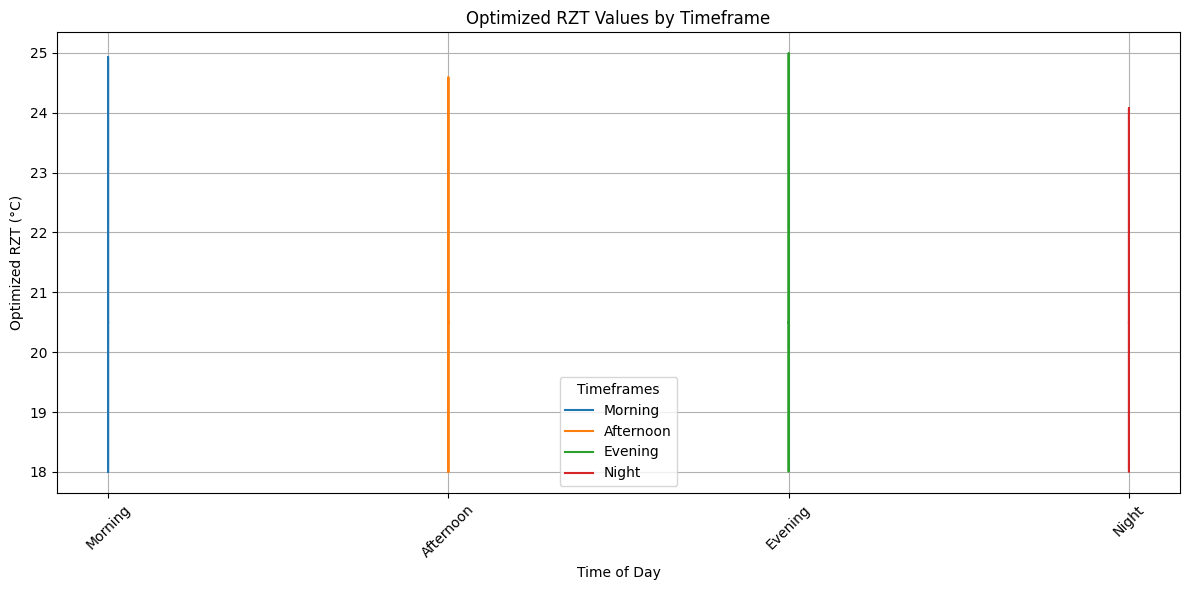

In [116]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
plt.figure(figsize=(12, 6))

# Plot the optimized RZT values for each timeframe
for timeframe in data['TimeOfDay'].unique():
    timeframe_data = data[data['TimeOfDay'] == timeframe]
    plt.plot(timeframe_data['TimeOfDay'], timeframe_data['Optimized_RZT'], label=timeframe)

# Add title and labels
plt.title('Optimized RZT Values by Timeframe')
plt.xlabel('Time of Day')
plt.ylabel('Optimized RZT (°C)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Timeframes')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
